_Lambda School Data Science — Practicing & Understanding Predictive Modeling_

# Review & Regularization

## Start with example solution for yesterday's assignment

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# We'll modify a project from Python Data Science Handbook by Jake VanderPlas
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic
    
# Predicting Bicycle Traffic

# As an example, let's take a look at whether we can predict the number of 
# bicycle trips across Seattle's Fremont Bridge based on weather, season, 
# and other factors.

# We will join the bike data with another dataset, and try to determine the 
# extent to which weather and seasonal factors—temperature, precipitation, 
# and daylight hours—affect the volume of bicycle traffic through this corridor. 
# Fortunately, the NOAA makes available their daily weather station data 
# (I used station ID USW00024233) and we can easily use Pandas to join 
# the two data sources.

def load(): 
    fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
    
    bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                         infer_datetime_format=True)

    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                          infer_datetime_format=True)

    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']] # remove other columns

    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    daily = daily.drop(index=daily.index[0])
    
    return daily

In [3]:
def split(daily):
    # Hold out an "out-of-time" test set, from the last 100 days of data
    
    train = daily[:-100]
    test = daily[-100:]
    
    X_train = train.drop(columns='Total')
    y_train = train.Total

    X_test  = test.drop(columns='Total')
    y_test  = test.Total
    ""
    return X_train, X_test, y_train, y_test

In [4]:
def jake_wrangle(X):  
    X = X.copy()

    # patterns of use generally vary from day to day; 
    # let's add binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)


    # we might expect riders to behave differently on holidays; 
    # let's add an indicator of this as well:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)


    # We also might suspect that the hours of daylight would affect 
    # how many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))


    # temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMAX'] /= 10

    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])


    # precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry day'] = (X['PRCP'] == 0).astype(int)


    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.

    return X

In [5]:
# Download and join data into a dataframe
data = load()

#### `SNOW` and `AWND` have minimums of `-9999` ...

In [6]:
data.describe(include='number')

,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,2632.449671,29.350894,-37.496707,0.098777,166.863594,84.472248,22.338664,2633.056444
std,1252.864020,65.813053,612.512583,2.570041,74.779734,50.916006,307.984292,1253.138245
min,98.000000,0.000000,-9999.000000,0.000000,-16.000000,-71.000000,-9999.000000,98.000000
25%,1806.000000,0.000000,0.000000,0.000000,111.000000,44.000000,22.000000,1806.000000
50%,2435.000000,0.000000,0.000000,0.000000,150.000000,83.000000,29.000000,2435.000000
75%,3574.500000,26.500000,0.000000,0.000000,222.000000,128.000000,40.000000,3574.500000
max,6088.000000,559.000000,74.000000,80.000000,356.000000,183.000000,95.000000,6088.000000


### Clean data and engineer features

In [7]:
def wrangle(X):
    X = X.copy()
    X = X.replace(-9999, 0)
    X = jake_wrangle(X)
    
    # DS1 DH
    X['PRCP_yesterday'] = X.PRCP.shift(1).fillna(X.PRCP.mean())
    X['Windchill'] = (((X['Temp (C)'] * (9/5) + 32) * .6215) + 34.74) - (35.75 * (X['AWND']** .16)) + (.4275 * (X['Temp (C)'])) * (X['AWND'] ** .16)
    X['Rl_Cold'] = (((X['Temp (C)'] * (9/5) + 32) - X['Windchill']) -32) * (5/9)
    X['TMIN_squared'] = X['TMIN'] **2
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i, month in enumerate(months):
        X[month] = (X.index.month == i+1).astype(float)
    
    # DS3 JD
    X['light_rain'] = (X['PRCP'] > 0) & (X['PRCP'] < 0.10)
    X['moderate_rain'] = (X['PRCP'] >= 0.1) & (X['PRCP'] < 0.30)
    X['heavy_rain'] = (X['PRCP'] >= 0.30)
    X['weekend_day'] = (X['Sat'] == 1) | (X['Sun'] == 1)

    return X

In [8]:
# Split data into train and test
X_train, X_test, y_train, y_test = split(data)

# Do the same wrangling to X_train and X_test
X_train = wrangle(X_train)
X_test  = wrangle(X_test)

### RandomizedSearchCV review / SPRINT CHALLENGE PRACTICE
- https://twitter.com/jakevdp/status/648593367786323968
- https://www.google.com/search?q=site%3Ascikit-learn.org+RandomizedSearchCV
  - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
  - https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
- https://www.google.com/search?q=XGBRegressor
  - https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://www.google.com/search?q=xgboost+parameter+tuning
  - https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
- https://nbviewer.jupyter.org/github/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb

In [9]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

param_distributions = {
    'n_estimators': randint(50, 500), 
    'max_depth': randint(1, 5)
}

search = RandomizedSearchCV(
    estimator=XGBRegressor(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=50,
    scoring='neg_mean_absolute_error', 
    n_jobs=-1, 
    cv=3, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

#search.fit(X_train, y_train)

In [10]:
search.fit(X_train,y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    9.9s finished
/home/jmurphy/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprec

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe88ca7ada0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe886671240>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [17]:
print('Mean Absolute Error with Cross-Validation:')
print(f'Predictions are off by {int(-search.best_score_)} bicyclists per day, on average')

Mean Absolute Error with Cross-Validation:
Predictions are off by 265 bicyclists per day, on average


In [19]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
41,0.200919,0.009815,0.005111,0.000165,4,99,"{'max_depth': 4, 'n_estimators': 99}",-239.140201,-299.719542,-258.634296,-265.831346,25.249584,1,-118.287817,-111.714466,-115.705761,-115.236015,2.704038
6,0.203486,0.014282,0.005506,0.000094,3,137,"{'max_depth': 3, 'n_estimators': 137}",-244.438229,-304.533409,-251.465551,-266.812396,26.826627,2,-147.865735,-142.781576,-148.144886,-146.264066,2.465127
2,0.227611,0.048321,0.007044,0.002623,3,121,"{'max_depth': 3, 'n_estimators': 121}",-243.344933,-304.401840,-254.079236,-267.275336,26.615651,3,-155.450152,-149.231834,-154.527866,-153.069951,2.739952
47,0.290568,0.014306,0.005834,0.000055,2,267,"{'max_depth': 2, 'n_estimators': 267}",-240.444091,-302.803964,-259.613981,-267.620679,26.080246,4,-169.646317,-160.380511,-166.519723,-165.515517,3.848819
32,0.319920,0.016993,0.007405,0.001919,2,291,"{'max_depth': 2, 'n_estimators': 291}",-241.840456,-303.311846,-259.036209,-268.062837,25.894567,5,-165.989825,-155.599304,-161.756025,-161.115051,4.266057


In [21]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').tail()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
29,0.142722,0.009494,0.005321,0.000978,1,216,"{'max_depth': 1, 'n_estimators': 216}",-289.782356,-328.937102,-323.153247,-313.957568,17.256765,46,-267.154350,-263.490960,-262.507895,-264.384402,1.999344
14,0.131762,0.003615,0.004928,0.000304,1,210,"{'max_depth': 1, 'n_estimators': 210}",-289.803013,-330.444365,-323.009156,-314.418845,17.668710,47,-268.307510,-264.348917,-263.597397,-265.417941,2.066140
7,0.137759,0.034377,0.009402,0.005824,1,149,"{'max_depth': 1, 'n_estimators': 149}",-293.405354,-342.035906,-328.566641,-321.335967,20.501132,48,-283.697866,-276.645941,-281.306564,-280.550123,2.928203
18,0.089419,0.010074,0.005083,0.000742,1,108,"{'max_depth': 1, 'n_estimators': 108}",-320.589672,-360.931201,-340.759934,-340.760269,16.469360,49,-303.647344,-292.263201,-300.832288,-298.914278,4.841401
3,0.056074,0.004328,0.004540,0.000818,1,70,"{'max_depth': 1, 'n_estimators': 70}",-346.360580,-397.258697,-363.825120,-369.148132,21.117219,50,-345.075502,-324.808175,-338.039347,-335.974341,8.401957


In [22]:
search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=99, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

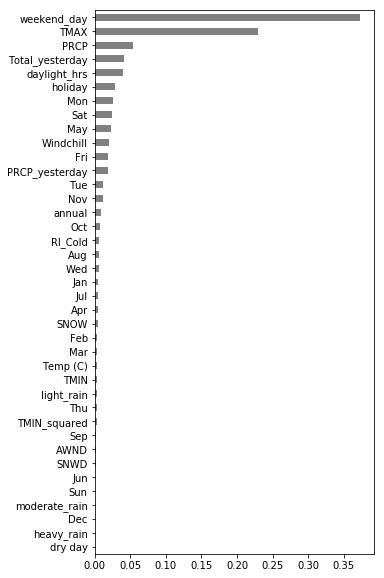

In [23]:
plt.figure(figsize=(5,10))
importances = pd.Series(search.best_estimator_.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='gray');

### Take the last step

Yesterday's assingment said,

At the end of the day, take the last step in the "universal workflow of machine learning" — "You can train your final production model on all the available data (training and validation) and evaluate it one last time on the test set."

See the [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) documentation for the `refit` parameter, `best_estimator_` attribute, and `predict` method:

> **refit : boolean, or string, default=True**

> Refit an estimator using the best found parameters on the whole dataset.

> The refitted estimator is made available at the `best_estimator_` attribute and permits using `predict` directly on this `GridSearchCV` instance.

In [24]:
from sklearn.metrics import mean_absolute_error
final = search.best_estimator_
y_pred = final.predict(X_test)  # We already wrangled X_test in the same way as X_train
test_mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error, with final model, on the hold-out test set:', test_mae)

Mean Absolute Error, with final model, on the hold-out test set: 252.56884338378907


## A few new things!
- Pipeline + RandomizedSearchCV
- SelectKBest for feature selection, in a pipeline
- Ridge Regression, a linear model with regularization

In [26]:
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

pipe = make_pipeline(
    RobustScaler(), 
    SelectKBest(f_regression), 
    Ridge())

param_distributions = {
    'selectkbest__k' : range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1.0, 10.]
}

search = RandomizedSearchCV(
    estimator=pipe, 
    param_distributions=param_distributions, 
    n_iter=100, 
    scoring='neg_mean_absolute_error', 
    n_jobs=-1, 
    cv=5, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1977s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1948s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 337 tasks      | elapsed:    4.1s
[Parallel(n_jo

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=10, score_func=<function f_regression at 0x7fe87ccc36a8>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'selectkbest__k': range(1, 40), 'ridge__alpha': [0.1, 1.0, 10.0]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [27]:
print('Mean Absolute Error with Cross-Validation:', -search.best_score_)

Mean Absolute Error with Cross-Validation: 311.816992628256


In [28]:
# Shows which features were selected
selector = search.best_estimator_.named_steps['selectkbest']
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\n', 'Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
PRCP
SNOW
SNWD
TMAX
TMIN
AWND
Total_yesterday
Mon
Tue
Wed
Thu
Fri
Sat
Sun
holiday
daylight_hrs
Temp (C)
dry day
annual
PRCP_yesterday
Windchill
Rl_Cold
TMIN_squared
Jan
Feb
Mar
Apr
May
Jun
Jul
Aug
Sep
Nov
Dec
light_rain
moderate_rain
heavy_rain
weekend_day

 Features not selected:
Oct


## Regularization with Linear Models

- https://www.google.com/search?q=site%3Ascikit-learn.org+regularization+%22linear+models%22
  - https://scikit-learn.org/stable/modules/linear_model.html
  - https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression
  - https://scikit-learn.org/stable/modules/linear_model.html#lasso
  - https://scikit-learn.org/stable/modules/linear_model.html#setting-regularization-parameter
  - https://scikit-learn.org/stable/modules/linear_model.html#using-cross-validation
    
> The [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer non-zero coefficients, effectively reducing the number of features upon which the given solution is dependent. 
  
> The `alpha` parameter controls the degree of sparsity of the estimated coefficients.
  
> scikit-learn exposes objects that set the Lasso `alpha` parameter by cross-validation: [`LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV) ...

Lasso Alpha: 0.01
Cross-Validated Mean Absolute Error: 301.2529542761344


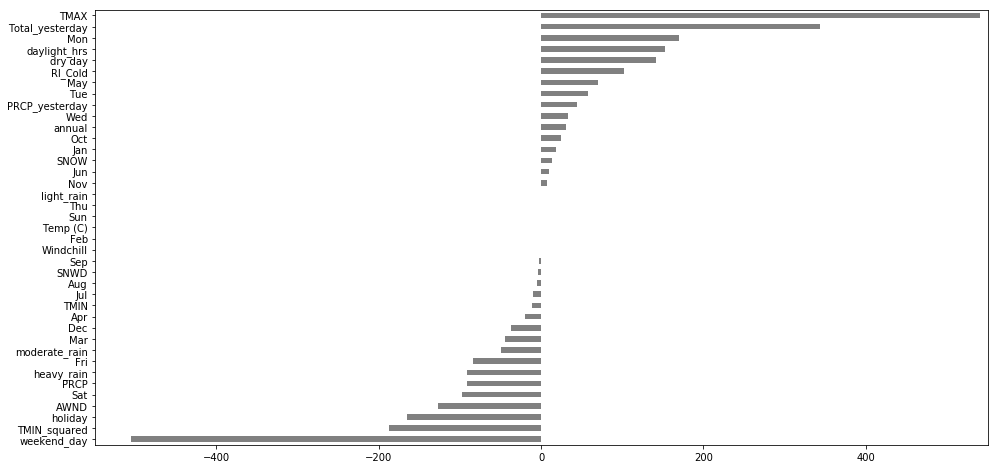

In [29]:
from ipywidgets import interact
from sklearn.exceptions import DataConversionWarning
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

def plot_lasso_coefs(power=-2):
    # Make pipeline with StandardScaler and Lasso Linear Model
    alpha = 10**power
    print(f'Lasso Alpha: {alpha}')
    pipe = make_pipeline(StandardScaler(), Lasso(alpha=alpha, max_iter=100000))
    
    # Get cross-validation scores
    maes = -cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=3)
    print('Cross-Validated Mean Absolute Error:', maes.mean())
    
    # Get coefficients
    pipe.fit(X_train, y_train)
    coefficients = pd.Series(pipe.named_steps['lasso'].coef_, X_train.columns)
    
    # Plot coefficients
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-550,550)

interact(plot_lasso_coefs, power=(-2,2,1));

In [30]:
from sklearn.linear_model import LassoCV

pipe = make_pipeline(StandardScaler(), LassoCV(cv=3))
pipe.fit(X_train, y_train)
lasso = pipe.named_steps['lassocv']
print('Lasso Linear Model, alpha value optimized with cross validation:', lasso.alpha_)

Lasso Linear Model, alpha value optimized with cross validation: 5.1962170868807505


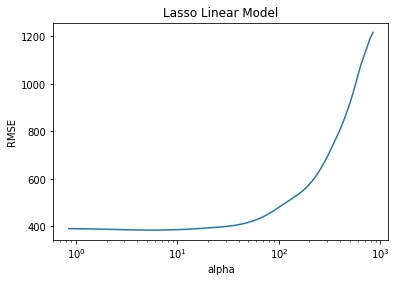

In [31]:
alphas = lasso.alphas_
mses = lasso.mse_path_.mean(axis=1)
rmses = np.sqrt(mses)
plt.plot(alphas, rmses)
plt.title('Lasso Linear Model')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.xscale('log');

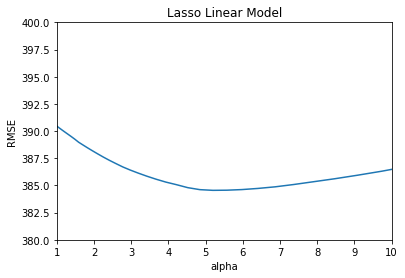

In [32]:
plt.plot(alphas, rmses)
plt.title('Lasso Linear Model')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.xlim(1,10)
plt.ylim(380,400);

## Want to learn more about regularized linear models?
- Aaron Gallant, [Ridge Regression](https://www.youtube.com/watch?v=XK5jkedy17w) (9 minute video)
- Selecting good features, [Part 2](https://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/) and [Part 4](https://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/)
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/), Chapters 3 & 6